In [1]:
import os
def mkdir(p):

  if not os.path.exists(p):

    os.mkdir(p)

In [2]:
def link(src,dst):

  if not os.path.exists(dst):
    os.symlink(src, dst, target_is_directory=True)

In [3]:
os.getcwd()

'C:\\Users\\raobk\\Desktop\\Advanced CV'

In [4]:
mkdir('C://Users//raobk//Desktop//Advanced CV//fruits//fruits-360_dataset/fruits-360/fruits-360-small')

In [5]:
classes = [

  'Apple Golden 1',

  'Avocado',

  'Lemon',

  'Mango',

  'Kiwi',

  'Banana',

  'Strawberry',

  'Raspberry'

]

In [6]:
train_path_from = os.path.abspath('C:/Users/raobk/Desktop/Advanced CV/fruits/fruits-360_dataset/fruits-360/Training')

In [7]:
valid_path_from = os.path.abspath('C:/Users/raobk/Desktop/Advanced CV/fruits/fruits-360_dataset/fruits-360/Test')

In [8]:
train_path_to = os.path.abspath('C:/Users/raobk/Desktop/Advanced CV/fruits/fruits-360_dataset/fruits-360/fruits-360-small/Training')

In [9]:
valid_path_to = os.path.abspath('C:/Users/raobk/Desktop/Advanced CV/fruits/fruits-360_dataset/fruits-360/fruits-360-small/Validation')

In [10]:
mkdir(train_path_to)

In [11]:
mkdir(valid_path_to)

In [12]:
os.chdir('C:/Users/raobk/Desktop/Advanced CV/fruits/fruits-360_dataset/fruits-360/')

In [13]:

for c in classes:
    link(train_path_from + '/' + c, train_path_to + '/' + c)
    link(valid_path_from + '/' + c, valid_path_to + '/' + c)

In [14]:
from __future__ import print_function, division

from builtins import range, input

In [19]:
from keras.layers import Input, Lambda, Dense, Flatten

from keras.models import Model

from keras.applications.vgg16 import VGG16

from keras.applications.vgg16 import preprocess_input

from keras.preprocessing import image

from keras.preprocessing.image import ImageDataGenerator

In [20]:
from sklearn.metrics import confusion_matrix

import numpy as np

import matplotlib.pyplot as plt



from glob import glob

In [21]:
# re-size all the images to this

IMAGE_SIZE = [100, 100] # feel free to change depending on dataset

In [22]:
# training config:

epochs = 5

batch_size = 32

In [23]:
train_path = 'C:/Users/raobk/Desktop/Advanced CV/fruits/fruits-360_dataset/fruits-360/fruits-360-small/Training'

In [24]:
valid_path = 'C:/Users/raobk/Desktop/Advanced CV/fruits/fruits-360_dataset/fruits-360/fruits-360-small/Validation'

In [25]:
# useful for getting number of files

image_files = glob(train_path + '/*/*.jp*g')

valid_image_files = glob(valid_path + '/*/*.jp*g')

In [26]:
# useful for getting number of classes

folders = glob(train_path + '/*')

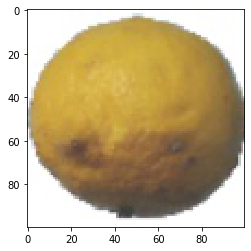

In [27]:
# look at an image for fun
plt.imshow(image.load_img(np.random.choice(image_files)))

plt.show()

In [28]:
# add preprocessing layer to the front of VGG
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [29]:
# don't train existing weights

for layer in vgg.layers:

  layer.trainable = False

In [30]:
# our layers - you can add more if you want

x = Flatten()(vgg.output)

# x = Dense(1000, activation='relu')(x)

prediction = Dense(len(folders), activation='softmax')(x)



In [31]:
# create a model object

model = Model(inputs=vgg.input, outputs=prediction)

In [32]:
# view the structure of the model

model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100, 100, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)       0   

In [33]:
# tell the model what cost and optimization method to use

model.compile(

  loss='categorical_crossentropy',

  optimizer='rmsprop',

  metrics=['accuracy']

)

In [34]:
# create an instance of ImageDataGenerator

gen = ImageDataGenerator(

  rotation_range=20,

  width_shift_range=0.1,

  height_shift_range=0.1,

  shear_range=0.1,

  zoom_range=0.2,

  horizontal_flip=True,

  vertical_flip=True,

  preprocessing_function=preprocess_input

)

In [35]:
# test generator to see how it works and some other useful things



# get label mapping for confusion matrix plot later

test_gen = gen.flow_from_directory(valid_path, target_size=IMAGE_SIZE)

print(test_gen.class_indices)

labels = [None] * len(test_gen.class_indices)

for k, v in test_gen.class_indices.items():

  labels[v] = k

Found 1289 images belonging to 8 classes.
{'Apple Golden 1': 0, 'Avocado': 1, 'Banana': 2, 'Kiwi': 3, 'Lemon': 4, 'Mango': 5, 'Raspberry': 6, 'Strawberry': 7}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


min: -81.36371 max: 151.061


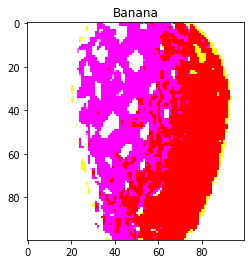

In [36]:
# should be a strangely colored image (due to VGG weights being BGR)

for x, y in test_gen:

  print("min:", x[0].min(), "max:", x[0].max())

  plt.title(labels[np.argmax(y[0])])

  plt.imshow(x[1])

  plt.show()

  break

In [33]:
# create generators

train_generator = gen.flow_from_directory(

  train_path,

  target_size=IMAGE_SIZE,

  shuffle=True,

  batch_size=batch_size,

)

Found 3839 images belonging to 8 classes.
Found 3839 images belonging to 8 classes.


In [34]:
valid_generator = gen.flow_from_directory(

  valid_path,

  target_size=IMAGE_SIZE,

  shuffle=True,

  batch_size=batch_size,

)



Found 1289 images belonging to 8 classes.
Found 1289 images belonging to 8 classes.


In [35]:
# fit the model

r = model.fit_generator(

  train_generator,

  validation_data=valid_generator,

  epochs=epochs,

  steps_per_epoch=len(image_files) // batch_size,

  validation_steps=len(valid_image_files) // batch_size,

)

Epoch 1/5
Epoch 1/5
119/119 [==============================] - 132s 1s/step - loss: 0.7753 - accuracy: 0.9469 - val_loss: 0.0437 - val_accuracy: 0.9883
Epoch 2/5
Epoch 2/5
119/119 [==============================] - 124s 1s/step - loss: 0.0486 - accuracy: 0.9929 - val_loss: 0.2414 - val_accuracy: 0.9602
Epoch 3/5
Epoch 3/5
119/119 [==============================] - 124s 1s/step - loss: 0.0222 - accuracy: 0.9958 - val_loss: 0.2471 - val_accuracy: 0.9881
Epoch 4/5
Epoch 4/5
119/119 [==============================] - 122s 1s/step - loss: 0.0131 - accuracy: 0.9984 - val_loss: 7.4506e-09 - val_accuracy: 0.9944
Epoch 5/5
Epoch 5/5
119/119 [==============================] - 122s 1s/step - loss: 0.0061 - accuracy: 0.9989 - val_loss: 0.0000e+00 - val_accuracy: 0.9722


In [36]:
def get_confusion_matrix(data_path, N):

  # we need to see the data in the same order

  # for both predictions and targets

  print("Generating confusion matrix", N)

  predictions = []

  targets = []

  i = 0

  for x, y in gen.flow_from_directory(data_path, target_size=IMAGE_SIZE, shuffle=False, batch_size=batch_size * 2):

    i += 1

    if i % 50 == 0:

      print(i)

    p = model.predict(x)

    p = np.argmax(p, axis=1)

    y = np.argmax(y, axis=1)

    predictions = np.concatenate((predictions, p))

    targets = np.concatenate((targets, y))

    if len(targets) >= N:

      break



  cm = confusion_matrix(targets, predictions)

  return cm





cm = get_confusion_matrix(train_path, len(image_files))

print(cm)





Generating confusion matrix 3839
Found 3839 images belonging to 8 classes.
Generating confusion matrix 3839
Found 3839 images belonging to 8 classes.
50
50
[[492   0   0   0   0   0   0   0]
 [  0 394   0   0   1  32   0   0]
 [  0   0 490   0   0   0   0   0]
 [  0   0   0 466   0   0   0   0]
 [  0   0   0   0 492   0   0   0]
 [  0   0   0   0   0 490   0   0]
 [  0   0   0   0   0   0 490   0]
 [  0   0   0   0   0   0   0 492]]
[[492   0   0   0   0   0   0   0]
 [  0 394   0   0   1  32   0   0]
 [  0   0 490   0   0   0   0   0]
 [  0   0   0 466   0   0   0   0]
 [  0   0   0   0 492   0   0   0]
 [  0   0   0   0   0 490   0   0]
 [  0   0   0   0   0   0 490   0]
 [  0   0   0   0   0   0   0 492]]


In [37]:
valid_cm = get_confusion_matrix(valid_path, len(valid_image_files))

print(valid_cm)

Generating confusion matrix 1289
Found 1289 images belonging to 8 classes.
Generating confusion matrix 1289
Found 1289 images belonging to 8 classes.
[[161   0   0   0   3   0   0   0]
 [  0 103   0   1   3  36   0   0]
 [  0   0 166   0   0   0   0   0]
 [  0   0   0 156   0   0   0   0]
 [  0   0   0   0 164   0   0   0]
 [  0   0   0   0   0 166   0   0]
 [  0   0   0   0   0   0 166   0]
 [  0   0   0   0   0   0   0 164]]
[[161   0   0   0   3   0   0   0]
 [  0 103   0   1   3  36   0   0]
 [  0   0 166   0   0   0   0   0]
 [  0   0   0 156   0   0   0   0]
 [  0   0   0   0 164   0   0   0]
 [  0   0   0   0   0 166   0   0]
 [  0   0   0   0   0   0 166   0]
 [  0   0   0   0   0   0   0 164]]


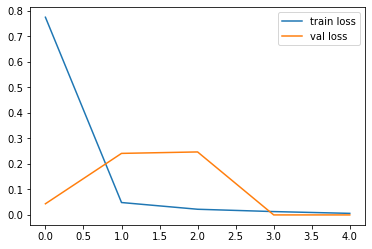

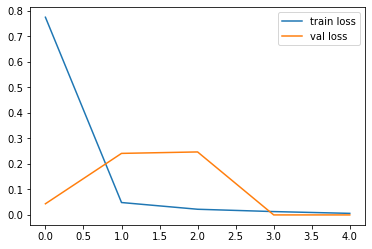

In [38]:
# plot some data
# loss

plt.plot(r.history['loss'], label='train loss')

plt.plot(r.history['val_loss'], label='val loss')

plt.legend()

plt.show()

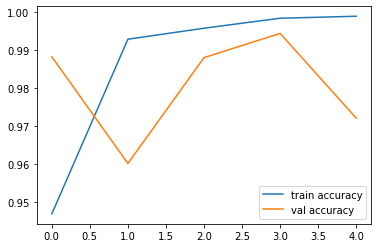

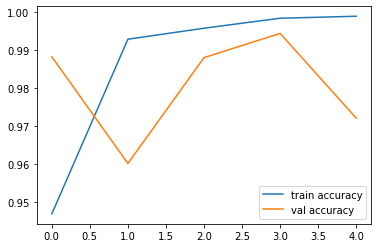

In [95]:
# accuracies

plt.plot(r.history['accuracy'], label='train accuracy')

plt.plot(r.history['val_accuracy'], label='val accuracy')

plt.legend()

plt.show()

Confusion matrix, without normalization
[[492   0   0   0   0   0   0   0]
 [  0 394   0   0   1  32   0   0]
 [  0   0 490   0   0   0   0   0]
 [  0   0   0 466   0   0   0   0]
 [  0   0   0   0 492   0   0   0]
 [  0   0   0   0   0 490   0   0]
 [  0   0   0   0   0   0 490   0]
 [  0   0   0   0   0   0   0 492]]
Confusion matrix, without normalization
[[492   0   0   0   0   0   0   0]
 [  0 394   0   0   1  32   0   0]
 [  0   0 490   0   0   0   0   0]
 [  0   0   0 466   0   0   0   0]
 [  0   0   0   0 492   0   0   0]
 [  0   0   0   0   0 490   0   0]
 [  0   0   0   0   0   0 490   0]
 [  0   0   0   0   0   0   0 492]]


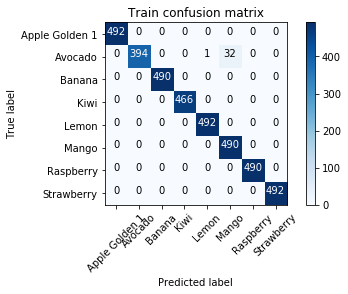

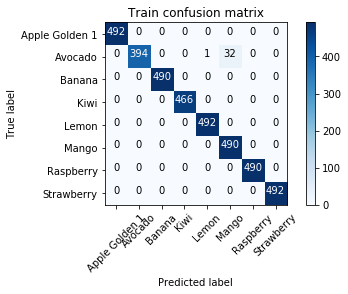

Confusion matrix, without normalization
[[161   0   0   0   3   0   0   0]
 [  0 103   0   1   3  36   0   0]
 [  0   0 166   0   0   0   0   0]
 [  0   0   0 156   0   0   0   0]
 [  0   0   0   0 164   0   0   0]
 [  0   0   0   0   0 166   0   0]
 [  0   0   0   0   0   0 166   0]
 [  0   0   0   0   0   0   0 164]]
Confusion matrix, without normalization
[[161   0   0   0   3   0   0   0]
 [  0 103   0   1   3  36   0   0]
 [  0   0 166   0   0   0   0   0]
 [  0   0   0 156   0   0   0   0]
 [  0   0   0   0 164   0   0   0]
 [  0   0   0   0   0 166   0   0]
 [  0   0   0   0   0   0 166   0]
 [  0   0   0   0   0   0   0 164]]


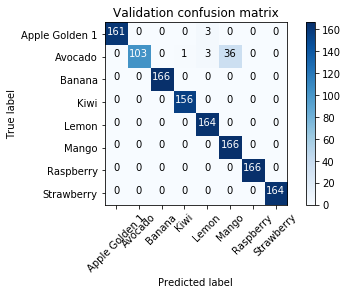

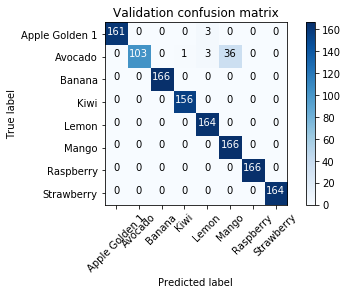

In [102]:

from util import util

util.plot_confusion_matrix(cm, labels, title='Train confusion matrix')

util.plot_confusion_matrix(valid_cm, labels, title='Validation confusion matrix')